In [4]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [6]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


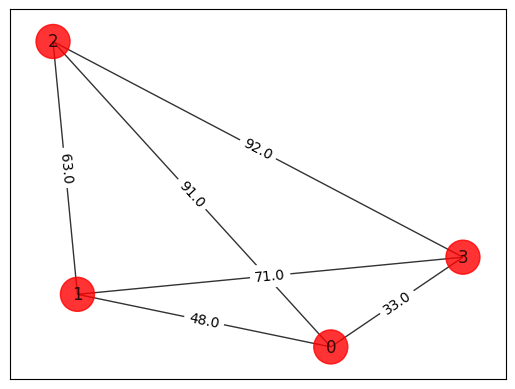

In [3]:
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


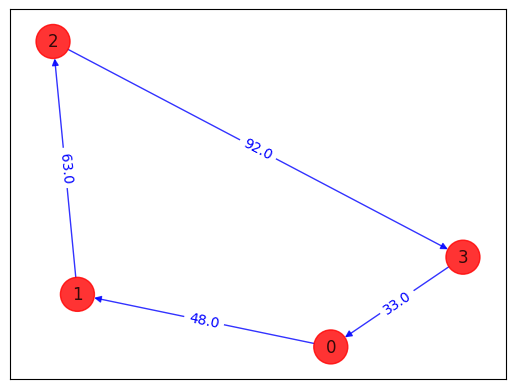

In [7]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [5]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [23]:
import numpy as np
import copy

from docplex.mp.model import Model

from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

In [7]:
result = CplexOptimizer().solve(qp)
print(result.prettyprint())

objective function value: 236.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=1.0
status: SUCCESS


In [8]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [9]:
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0
)

In [10]:
import time

In [11]:
start = time.time()
ws_result = ws_qaoa.solve(qp)
end = time.time()
print(ws_result.prettyprint())
print(f"Time to solve: {end-start}")

objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
Time to solve: 246.3324601650238


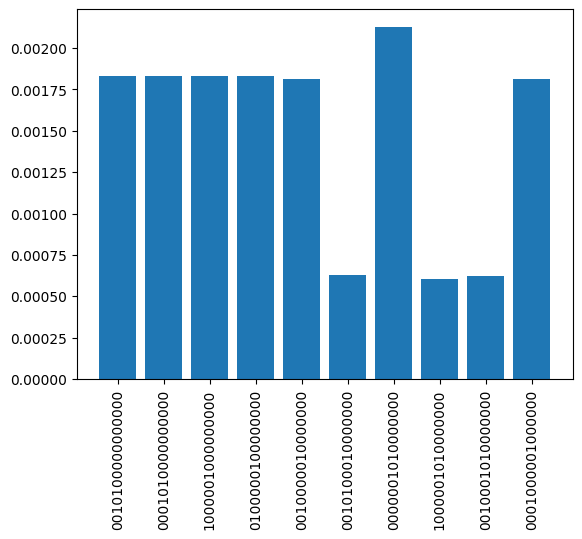

In [12]:
def samples_to_graph(data):
    data_val={}
    data_prob={}
    for i in data:
        arr=i.x.tolist()
        arr=[str(int(i)) for i in arr]
        key=''.join(arr)
        data_val[key]=i.fval
        data_prob[key]=i.probability
    data_val_sorted=sorted(data_val, key=data_val.get)
    least_10=data_val_sorted[0:10]
    plot_dic={}
    for i in least_10:
        plot_dic[i]=data_prob[i]
    plt.xticks(rotation=90)
    plt.bar(range(len(plot_dic)), plot_dic.values(), tick_label=least_10)
    
    return least_10[0], plot_dic

optimal_10_warm_start, optimal_10_prob_warm_start = samples_to_graph(ws_result.samples)

solution: [3, 2, 1, 0]
solution objective: 236.0


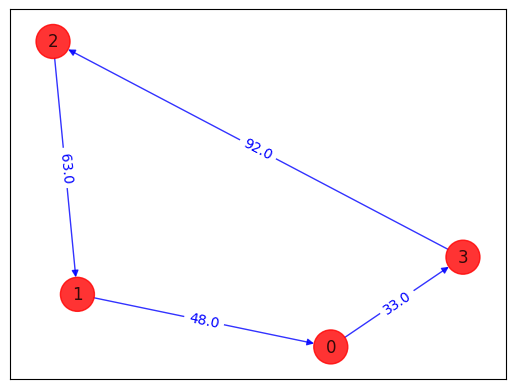

In [14]:
# x = tsp.sample_most_likely(ws_result.min_eigen_solver_result)
# x = tsp.sample_most_likely(ws_qaoa)
# print("feasible:", qp.is_feasible(ws_result))
z = tsp.interpret(ws_result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [34]:
for i in range(len(ws_result.x.tolist())):
    print(ws_result.x.tolist()[i])

0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0


In [ ]:
# def format_qaoa_samples(samples, max_len: int = 10):
#     qaoa_res = []
#     for s in samples:
#         qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))

#     # res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
#     res = qaoa_res

#     return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]
# format_qaoa_samples(ws_result.samples)

In [16]:
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()

In [17]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [19]:
start = time.time()
qaoa_result = qaoa.solve(qp)
end = time.time()
print(f"Time to solve: {end-start} seconds")
print(qaoa_result.prettyprint())

Time to solve: 367.44413232803345 seconds
objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


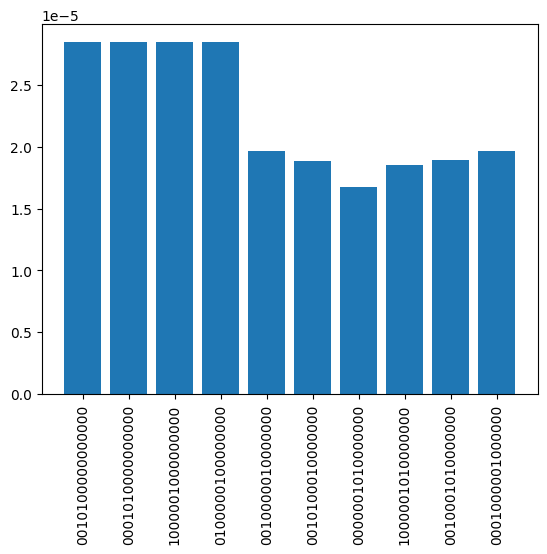

In [23]:
optimal_10_regular, optimal_10_prob_regular = samples_to_graph(qaoa_result.samples)

solution: [3, 2, 1, 0]
solution objective: 236.0


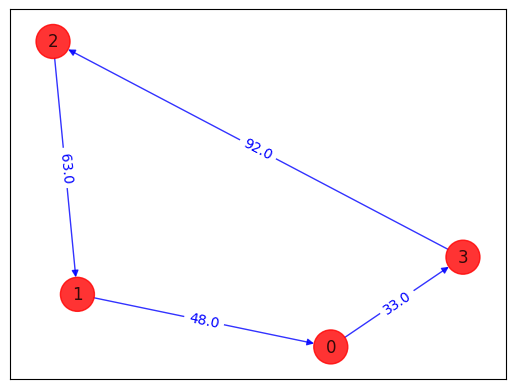

In [21]:
z = tsp.interpret(qaoa_result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [9]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

%config InlineBackend.figure_format='retina'

In [11]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="8c9e4999a60d7a4b22e720df03a7389ea8afad14c5dc67f359465638aae27d2f590e19704de9232c632d98b153cf344af9996a247406827b8dcdada6507c4652")

In [12]:
service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")

In [15]:
session = Session(backend=backend)

estimator = Estimator(session=session, options={"shots": int(1e4)})
sampler = Sampler(session=session, options={"shots": int(1e4)})

In [18]:
n = 5
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
# print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
# draw_graph(tsp.graph, colors, pos)

qp = tsp.to_quadratic_program()

In [19]:
qp.objective

<QuadraticObjective: minimize 48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 +...>

In [31]:
from dataclasses import dataclass

val = 0

@dataclass
class QAOALog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~30", end="\r", flush=True)

log = QAOALog([], [])

In [32]:
qaoa_mes = QAOA(sampler=Sampler(), 
                optimizer=COBYLA(), 
                callback=log.update,
                initial_point=[0.0, 1.0])
qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qp)
print(qaoa_result.prettyprint())

objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


In [38]:
print(len(log.values)) # number of iterations
print(log.values)

31
[0j, (1525.217261512948+0j), 0j, (2816.746203902231+0j), (2216.86885675954+0j), (447.92510460032065+0j), 0j, (759.1007429731148+0j), (234.2698544283881+0j), (4.612206834024675+0j), (28.270286418312534+0j), 0j, (-7.783741791386117+0j), (4.612206834024675+0j), (-4.076705602038147+0j), (23.198760518216968+0j), (-4.444407597188157+0j), (-2.8100926814849023+0j), (-21.81783700980035+0j), (5.791333338763361+0j), (149.5427282031322+0j), (-14.115092962840983+0j), (-84.29981182905716+0j), (-68.8137525320757+0j), (-76.68618540825646+0j), (1.2712526106104294+0j), (63.95983365310798+0j), (18.91246989618253+0j), (-40.9247628683827+0j), (-70.20962626236647+0j), (-76.92967481173604+0j)]


In [37]:
print(log.parameters)

[[0.0, 1.0], [1.0, 1.0], [0.0, 2.0], [-1.0, 1.0], [-0.5, 1.0], [0.25, 1.0], [0.0, 1.125], [-0.25, 1.0], [-0.125, 1.0], [0.0625, 1.0], [-0.03125, 1.0], [0.0, 1.015625], [0.03125, 1.0], [0.0625, 1.0], [0.046875, 1.0], [0.03125, 0.9921875], [0.030316907744945013, 1.0155971139587925], [0.02562047909628614, 0.9945830220007232], [0.03511416040753405, 0.9994281141658108], [0.03822706583155697, 0.9970683241574438], [0.03632232242398113, 1.0031428326752694], [0.03498255136243149, 0.9974794283715196], [0.03584756688234238, 1.0000729313950436], [0.03682389230257268, 1.000051414187549], [0.03573176895328243, 1.0010426041006673], [0.035430312888729096, 0.9998193220815015], [0.03584190976365226, 1.0003170064691163], [0.036015986081772096, 0.9998961840668068], [0.03575802378287669, 1.0000284113620463], [0.035825306865843745, 1.0001177029447765], [0.035946909113353714, 1.0000614805811996]]
